# import

In [1]:

# Step 1: Imports
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
# Custom preprocessing functions
import sys, os
sys.path.append(os.path.abspath('..'))
from src.data_processing import load_data, clean_data, feature_engineer_fraud, transform_data

c:\Users\user\Desktop\Project\Adey_Innovations\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#  Load Model and Data

In [4]:
fraud_df = load_data(r"C:\Users\user\Desktop\Project\Adey_Innovations\data\raw\Fraud_Data.csv")
ip_df = load_data(r"C:\Users\user\Desktop\Project\Adey_Innovations\data\raw\IpAddress_to_Country.csv")

# Preprocess data

In [5]:
# Step 3: Preprocess data
fraud_df = clean_data(fraud_df)
fraud_df = feature_engineer_fraud(fraud_df, ip_df)

num_cols_fraud = ['purchase_value', 'age', 'hour_of_day', 'time_since_signup', 'device_id_count', 'ip_address_count']
cat_cols_fraud = ['source', 'browser', 'sex']

fraud_transformed, _ = transform_data(fraud_df, cat_cols_fraud, num_cols_fraud)

cols_to_drop = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'country', 'ip_int', 'lower_bound_ip_address', 'upper_bound_ip_address', 'day_of_week']
X_fraud = fraud_transformed.drop(columns=[col for col in cols_to_drop if col in fraud_transformed.columns] + ['class'])
y_fraud = fraud_transformed['class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud)

 # Train XGBoost model 

In [6]:

X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce').astype(float)
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce').astype(float)

xgb_model = XGBClassifier(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_numeric, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

#  SHAP Explainability

In [7]:

explainer = shap.Explainer(xgb_model, X_train_numeric)
shap_values = explainer(X_test_numeric)

 99%|===================| 29998/30223 [01:40<00:00]        

# Summary plot

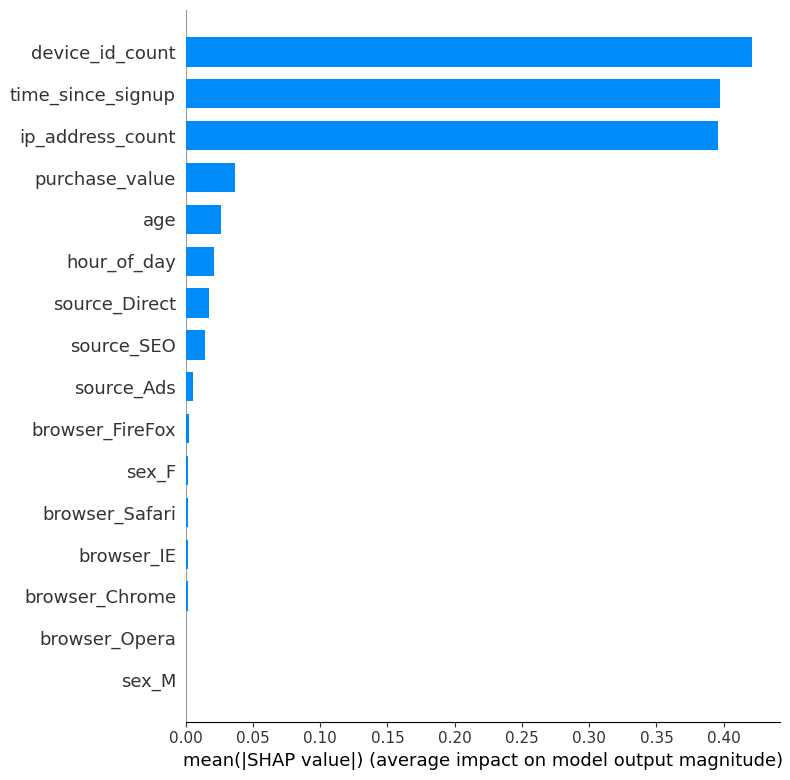

In [8]:

plt.figure(figsize=(12,6))
shap.summary_plot(shap_values, X_test_numeric, plot_type="bar")

#  SHAP beeswarm plot

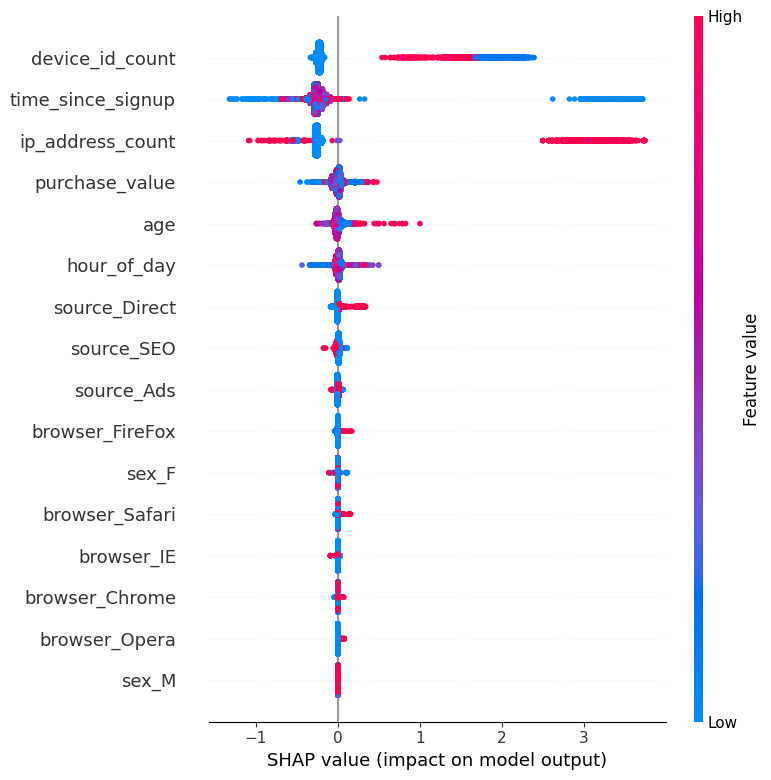

In [9]:

plt.figure(figsize=(12,6))
shap.summary_plot(shap_values, X_test_numeric)

# SHAP force plot for single prediction

In [10]:

idx = 0  # first test sample
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[idx].values, X_test_numeric.iloc[idx])

# SHAP dependence plot 

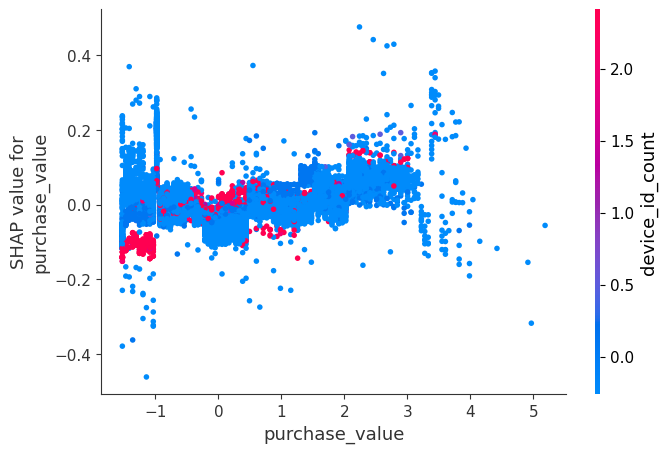

In [11]:

shap.dependence_plot("purchase_value", shap_values.values, X_test_numeric)

#  Save SHAP values for later analysis

In [12]:

shap_values_df = pd.DataFrame(shap_values.values, columns=X_test_numeric.columns)
shap_values_df.to_csv(r"C:\Users\user\Desktop\Project\Adey_Innovations\data\processed\shap_values.csv", index=False)